# Identificación de tendencias con trendet y comparación de sentimiento con el comportamiento del mercado con datos de investpy y twipper

**por Álvaro Bartolomé del Canto @ alvarob96 en GitHub**

---
## Introducción

In [1]:
import trendet

In [2]:
(trendet.__author__, trendet.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.3')

In [3]:
df = trendet.identify_all_trends(equity='bbva',
                                 country='spain',
                                 from_date='01/01/2018',
                                 to_date='01/01/2019',
                                 window_size=5)

In [4]:
df.head()

,Close,High,Low,Open,Volume,Up Trend,Down Trend
Date,,,,,,,
2018-01-02,7.082,7.169,7.050,7.139,15960000,A,NaN
2018-01-03,7.094,7.120,7.055,7.113,13320000,A,NaN
2018-01-04,7.221,7.274,7.104,7.113,20790000,A,NaN
2018-01-05,7.253,7.282,7.203,7.259,13580000,A,NaN
2018-01-08,7.235,7.293,7.220,7.274,13420000,A,NaN


In [5]:
up_trends = df['Up Trend'].dropna().unique().tolist()

In [6]:
down_trends = df['Down Trend'].dropna().unique().tolist()

In [7]:
df.reset_index(inplace=True)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


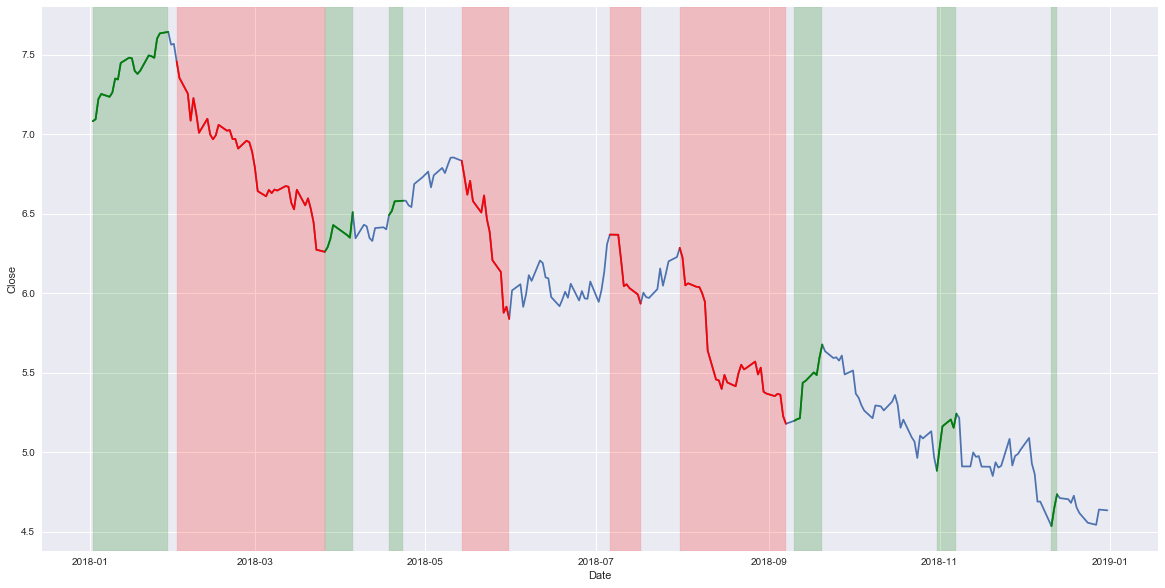

In [9]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(20, 10))

    ax = sns.lineplot(x=df['Date'], y=df['Close'])

    labels = df['Up Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Up Trend'] == label]['Date'],
                     y=df[df['Up Trend'] == label]['Close'],
                     color='green')

        ax.axvspan(df[df['Up Trend'] == label]['Date'].iloc[0],
                   df[df['Up Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='green')

    labels = df['Down Trend'].dropna().unique().tolist()

    for label in labels:
        sns.lineplot(x=df[df['Down Trend'] == label]['Date'],
                     y=df[df['Down Trend'] == label]['Close'],
                     color='red')

        ax.axvspan(df[df['Down Trend'] == label]['Date'].iloc[0],
                   df[df['Down Trend'] == label]['Date'].iloc[-1],
                   alpha=0.2,
                   color='red')

    plt.show()

In [10]:
for down_trend in down_trends:
    print(df[df['Down Trend'] == down_trend]['Date'].tolist()[0].strftime('%Y%m%d%H%S'),
          df[df['Down Trend'] == down_trend]['Date'].tolist()[-1].strftime('%Y%m%d%H%S'))
    print(df[df['Down Trend'] == down_trend]['Close'].tolist()[0],
          df[df['Down Trend'] == down_trend]['Close'].tolist()[-1])

201802010000 201803260000
7.458 6.261
201805140000 201805310000
6.833 5.839
201807060000 201807170000
6.369 5.935
201807310000 201809070000
6.286 5.18


__La tendencia a analizar es la que corresponde al periodo comprendido entre: '201805140000' y '201805310000'. En este caso es una tendencia bearish, en la que el mercado cambia de manera abrupta de una forma muy negativa, bajando su valor en bolsa de '6.833' a '5.839', en un periodo inferior a 15 días.__

__De este modo, ahora a partir de la información de Twitter extraida a través de [twipper](https://github.com/alvarob96/twipper/) se pretende analizar el impacto de la opinión volcada en Twitter por los usuarios analizando su sentimiento, con el fin de determinar si afecta de un modo negativo al comportamiento del mercado y, así de algún modo, condiciona el mismo.__

In [14]:
import twipper

In [15]:
(twipper.__author__, twipper.__version__)

('Alvaro Bartolome @ alvarob96 on GitHub', '0.1.2')

In [17]:
cred = twipper.Twipper(consumer_key='Si1dJus1cp3YefEzGsnbLh37u',
                       consumer_secret='vDoaKZ49J2IfCO9BeM8hWONPd0AF00wxfQ16ilhKlEKz66pqZv',
                       access_token='894988499526590464-QgT79lu6fvoQRwvRGw0MQDZW7e2EaAn',
                       access_token_secret='7GJtpiddHDiMfNh1juHZuhZfjIbhBDzo5gVt6ss65UbR9')

In [18]:
cred.plan = 'fullarchive'
cred.label = 'research'

In [48]:
from twipper.premium import search_tweets

In [49]:
# tweets = search_tweets(access=cred,
#                        query='bbva',
#                        page_count=1,
#                        from_date='201805140000',
#                        to_date='201805310000',
#                        language='es')

In [50]:
len(tweets)

100

In [51]:
for tweet in tweets:
    if 'retweeted_status' in tweet:
        if 'extended_tweet' in tweet['retweeted_status']:
            print(tweet['retweeted_status']['extended_tweet']['full_text'])
    elif 'extended_tweet' in tweet:
        print(tweet['extended_tweet']['full_text'])
    else:
        print(tweet['text'])

"Diez nuevos perfiles profesionales en la construcción", interesante artículo en Anida (Grupo BBVA). El futuro del sector pasa por la "reconversión" y "transformación" de los negocios de arquitectura hacia lo digital.
#Arquiknowamadas
#TriunfaConTuEstudio

https://t.co/CDWsWH00UR https://t.co/7Xmip75CWJ
El jefe de Seguridad del BBVA contrató a Villarejo en 2014,cuando aún estaba en activo, para mediar en el acoso y presuntos chantajes de Ausbanc.
#CloacasDelnterior
#diaDelPerroSinRaza
▶ https://t.co/yVplbosIgF https://t.co/v8STYtXKl6
Lista mundial:
-Rajoy
-Urdangarin
-Aguirre
-Gallardón
-Pérez 
-el otro 
-su yerno
-el suegro de su amiga 
-Rato
-Aznar
-Trillo
-el curita
-J.M Soria 
-Chaves
-Griñán
-Pujol 
-N. Serra
-Billy el Niño
-Loquillo
Patrocinadores:
BBVA-Caixa-iberdrola-Endesa-Prisa-La Patri-Telefonica https://t.co/1EmC9l9FjP
@mats_cc Te comentamos que BBVA Bancomer, S.A., Av. Paseo de la Reforma 510, Col. Juárez, Delegación Cuauhtémoc, 06600, DF, recaba tus datos para verificar t

In [52]:
res = list()

In [53]:
for tweet in tweets:
    if 'retweeted_status' in tweet:
        res.append(tweet['retweeted_status']['id_str'])
    else:
        res.append(tweet['id_str'])

In [54]:
len(res)

100

In [55]:
len(list(dict.fromkeys(res)))

44

---
## Licencia

MIT License

Copyright (c) 2019 Álvaro Bartolomé del Canto

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---
## Autor

**Álvaro Bartolomé del Canto, 2018-2019**